In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision.models import vgg19
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

##Content Loss

In [ ]:
class Vgg19(nn.Module):
    def __init__(self):
        super(Vgg19, self).__init__()
        self.vgg19 = vgg19(pretrained=True).eval().to(device)

    def forward(self, x):
        features = []
        for layer in self.vgg19.features:
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                features.append(x)
        return features

In [ ]:
to_input = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.unsqueeze(0).to(device)),
])

We also provide the inverse transformation so that we can convert from the PyTorch tensors we are optimizing to images we can visualize.

In [ ]:
to_output = T.Compose([
    T.Lambda(lambda x: (x - x.min())/(x.max()-x.min())),
    T.Lambda(lambda x: x.squeeze().cpu()),
    T.ToPILImage()
])

The training loop is:
1. Compute the features of the content image
2. Initialize a white noise image and optimizer
3. Compute the features of the white noise image
4. Compute the loss between the features of the content image and the white noise image
5. Perform an optimization step to minimize the loss with respect to the white noise image
6. Repeat from step 3 until done.

In [ ]:
def fit_content(model, content_image,
              content_layer=4,
              epochs=1000, lr=1e-1):

    content_features = model(content_image)

    img = 1e-1*torch.randn_like(content_image, device=device)
    img.requires_grad_(True)

    opt = torch.optim.Adam([img], lr=lr)

    for epoch in range(epochs):
        opt.zero_grad()

        features = model(img)

        content = features[content_layer]
        content_target = content_features[content_layer].detach()
        loss = ((content - content_target)**2).sum()

        loss.backward()
        opt.step()

    return to_output(img)

Let's look at the image we get when we optimize for progressively deeper layers of the network:

In [ ]:
vgg19 = Vgg19()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 73.0MB/s]


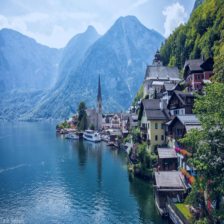

In [ ]:
content_image = to_input(Image.open('hallstatt.png'))
to_output(content_image)

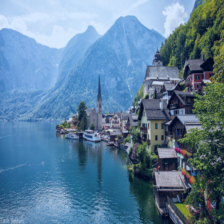

In [ ]:
fit_content(vgg19, content_image, content_layer=0)

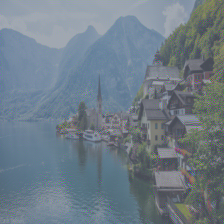

In [ ]:
fit_content(vgg19, content_image, content_layer=2)

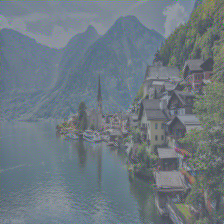

In [ ]:
fit_content(vgg19, content_image, content_layer=4)

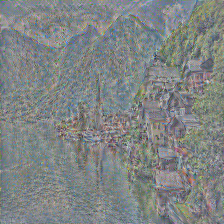

In [ ]:
fit_content(vgg19, content_image, content_layer=8)

## Style loss



In [ ]:
def gram_matrix(features):
    # first dimension is batch dimension
    _, c, h, w = features.size()
    features = features.view(c, h*w)
    return features@features.T

In [ ]:
def fit_style(model, style_image,
              style_layer=4,
              epochs=1000, lr=1e-1):

    style_features = model(style_image)

    img = 1e-1*torch.randn_like(style_image, device=device)
    img.requires_grad_(True)

    opt = torch.optim.Adam([img], lr=lr)

    for epoch in range(epochs):
        opt.zero_grad()

        features = model(img)

        style = gram_matrix(features[style_layer])
        style_target = gram_matrix(style_features[style_layer].detach())
        loss = ((style - style_target)**2).sum()

        loss.backward()
        opt.step()

    return to_output(img)

Like above, we can see how fitting to the style of an image at different layers changes the effects:

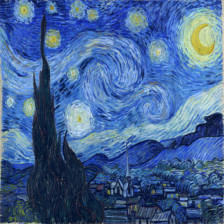

In [ ]:
style_image = to_input(Image.open('starry_night.png'))
to_output(style_image)

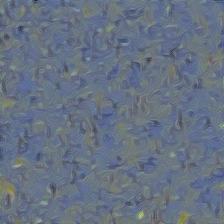

In [ ]:
fit_style(vgg19, style_image, style_layer=1)

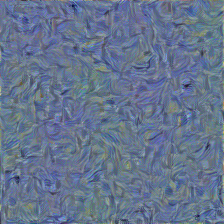

In [ ]:
fit_style(vgg19, style_image, style_layer=2)

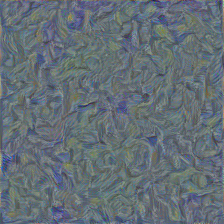

In [ ]:
fit_style(vgg19, style_image, style_layer=3)

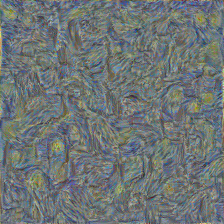

In [ ]:
fit_style(vgg19, style_image, style_layer=4)

## Putting them together


In [ ]:
def fit(model, style_image, content_image,
              style_weight=1e-2, content_weight=1e2,
              style_layers=[0, 1, 2, 3, 4], content_layers=[4],
              epochs=1000, lr=1e-1):

    content_features = model(content_image)
    style_features = model(style_image)

    img = 1e-1*torch.randn_like(style_image,
                            device=device)

    img.requires_grad_(True)

    opt = torch.optim.Adam([img], lr=lr)

    for epoch in range(epochs):
        opt.zero_grad()

        features = model(img)

        content_loss = 0
        for layer in content_layers:
            content = features[layer]
            content_target = content_features[layer].detach()
            content_loss += ((content - content_target)**2).sum()

        style_loss = 0
        for layer in style_layers:
            style = gram_matrix(features[layer])
            style_target = gram_matrix(style_features[layer]).detach()
            style_loss += ((style - style_target)**2).sum()

        loss = content_weight*content_loss/len(content_layers) \
               + style_weight*style_loss/len(style_layers) \

        loss.backward()
        opt.step()

    return to_output(img)

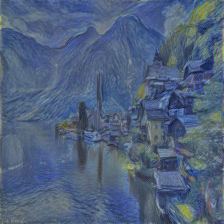

In [ ]:
fit(vgg19, style_image, content_image)

## Further implementation

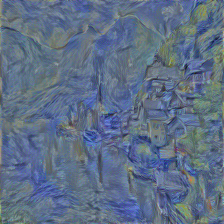

In [ ]:
fit(vgg19, style_image, content_image, lr=1e-2)

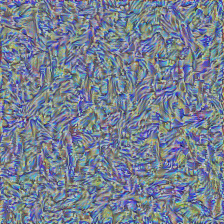

In [ ]:
fit(vgg19, style_image, content_image, lr=1e-3)

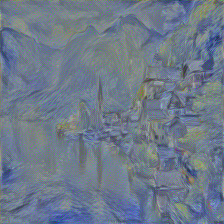

In [ ]:
fit(vgg19, style_image, content_image, lr=1)

## Change the content layer:

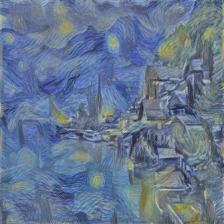

In [ ]:
fit(vgg19, style_image, content_image, content_layers=[0])

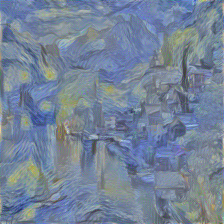

In [ ]:
fit(vgg19, style_image, content_image, content_layers=[10])

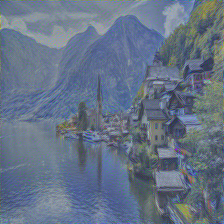

In [ ]:
fit(vgg19, style_image, content_image, content_weight=1e3)

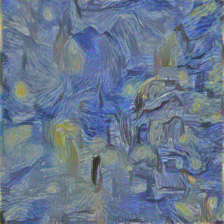

In [ ]:
fit(vgg19, style_image, content_image, content_weight=1e1)